In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('real_estate.csv')

df.sample(5)

df = df.dropna(axis=0, how='any', subset = ['brokered_by', 'price', 'street', 'city'])
df = df.drop(['status', 'zip_code', 'prev_sold_date'], axis = 1)

df2 = df.groupby(['state']).get_group('New York')

address_info = df2[['street', 'city', 'state', 'brokered_by', 'price']].reset_index(drop=True)

print(f"Count total NaN at each column in a DataFrame: \n\n{df2.isnull().sum()}")

Count total NaN at each column in a DataFrame: 

brokered_by        0
price              0
bed            16047
bath           13133
acre_lot       28592
street             0
city               0
state              0
house_size     29838
dtype: int64


C:\Users\DhM\AppData\Local\Temp\ipykernel_34052\444173281.py:14: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df2 = df.groupby(['state']).get_group('New York')


# You can take the original dataset from the link we provided in excel and step-by-step create the dataset that is used for every computation here
# https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset?resource=download
# Except for the second part
# Part 1
#### Above is code to take only new york rows from the original dataset
#### We also show the number of NaNs

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["price", "acre_lot", "street"], axis=1),
    df2["price"],
    test_size=0.2,
    random_state=0,
)
non_impute_columns = ["city", "state", "brokered_by"]
num_columns = X_train.drop(non_impute_columns, axis=1).columns

scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=5, weights="distance").set_output(transform="pandas")

X_scaled_train_num = scaler.fit_transform(X_train[num_columns])
X_scaled_test_num = scaler.transform(X_test[num_columns])

X_train_num_imputed = imputer.fit_transform(X_scaled_train_num)
X_test_num_imputed = imputer.transform(X_scaled_test_num)

X_train_num_descaled = pd.DataFrame(scaler.inverse_transform(X_train_num_imputed), columns=num_columns)
X_test_num_descaled = pd.DataFrame(scaler.inverse_transform(X_test_num_imputed), columns=num_columns)

X_train_combined = pd.concat([X_train_num_descaled, X_train[non_impute_columns].reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([X_test_num_descaled, X_test[non_impute_columns].reset_index(drop=True)], axis=1)

y_train_reset = y_train.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

X_train_combined['price'] = y_train_reset
X_test_combined['price'] = y_test_reset

final_imputed_dataset = pd.concat([X_train_combined, X_test_combined], axis=0)

final_imputed_dataset.to_csv('imputed_real_estate_dataset.csv', index=False)
# df2 = df.groupby(['state'])['state'].count()
# df2 = df2.sort_values(ascending=True)

# print("Get count of each group:\n", df2)

#### Above is the code to impute the dataset using KNN

In [31]:
df = pd.read_csv('imputed_real_estate_dataset.csv')
print(f"Count total NaN at each column in New York DataFrame: \n\n{df.isnull().sum()}")

Count total NaN at each column in New York DataFrame: 

bed            0
bath           0
house_size     0
city           0
state          0
brokered_by    0
price          0
dtype: int64


#### Above is code to make sure no NaNs remain

In [32]:
import numpy as np

def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = df.drop(columns=['brokered_by'])

df['log_bed'] = np.log(df['bed'].replace(0, np.nan)) 
df['log_bath'] = np.log(df['bath'].replace(0, np.nan))

df['square_bed'] = df['bed'] ** 2
df['square_bath'] = df['bath'] ** 2

top_30_cities = df['city'].value_counts().nlargest(30).index
df['city_grouped'] = df['city'].apply(lambda x: x if x in top_30_cities else 'Other')

df = pd.get_dummies(df, columns=['city_grouped'], prefix='city', drop_first=False)

df = df.drop(columns=['city', 'state'])

columns_to_check = ['bed', 'bath', 'house_size', 'log_bed', 'log_bath', 'square_bed', 'square_bath', 'price']

df_cleaned = remove_outliers_iqr(df, columns_to_check)
print(f'Number of rows after removing outliers: {len(df_cleaned)}')

columns_to_scale = ['bed', 'bath', 'house_size', 'log_bed', 'log_bath', 'square_bed', 'square_bath']

df_cleaned[columns_to_scale] = scaler.fit_transform(df_cleaned[columns_to_scale])

df_cleaned.to_csv("cleaned_dataset.csv", index=False)

print("Modified dataset saved to 'cleaned_dataset.csv'")

Number of rows after removing outliers: 74777
Modified dataset saved to 'cleaned_dataset.csv'


#### Above is code to make a dataset with logs and squares of bath and bed
#### Then we take first 30 cities and one hot encode them into additional features
#### We also scale the numerical features for ease of use

In [33]:
import pandas as pd

df = pd.read_csv('cleaned_dataset.csv')

threshold = 0.1

df_cleaned = df[df['price'] > threshold]

df_cleaned.to_csv('cleaned_dataset_without_close_to_zero.csv', index=False)

print("Entries with price close to 0 have been removed.")

Entries with price close to 0 have been removed.


#### For some unknown reason there was an entry with price equal to 0, which is obviously useless data


Polynomial Degree: 1
R-squared (Training set): 0.45153396074302776
R-squared (Validation set): 0.4609766953134671
R-squared (Test set): 0.46846805946780923
MSE (Training set): 53241705580.10085
MSE (Validation set): 50703299751.10987
MSE (Test set): 52972413659.84952
MAE (Training set): 174365.37697031253
MAE (Validation set): 169448.62053224974
MAE (Test set): 175039.0983562878
MAPE (Training set): 28.106722144675246
MAPE (Validation set): 28.009771786779385
MAPE (Test set): 51.51313887786098

Polynomial Degree: 2
R-squared (Training set): 0.4819211218017597
R-squared (Validation set): 0.4918183105102284
R-squared (Test set): 0.4985539387868104
MSE (Training set): 50291907111.82031
MSE (Validation set): 47802179063.87135
MSE (Test set): 49974058296.65018
MAE (Training set): 169182.5337846874
MAE (Validation set): 164170.00106980477
MAE (Test set): 169237.6087189088
MAPE (Training set): 30.46461287011195
MAPE (Validation set): 24.6357159457556
MAPE (Test set): 23.549307502091683

Poly

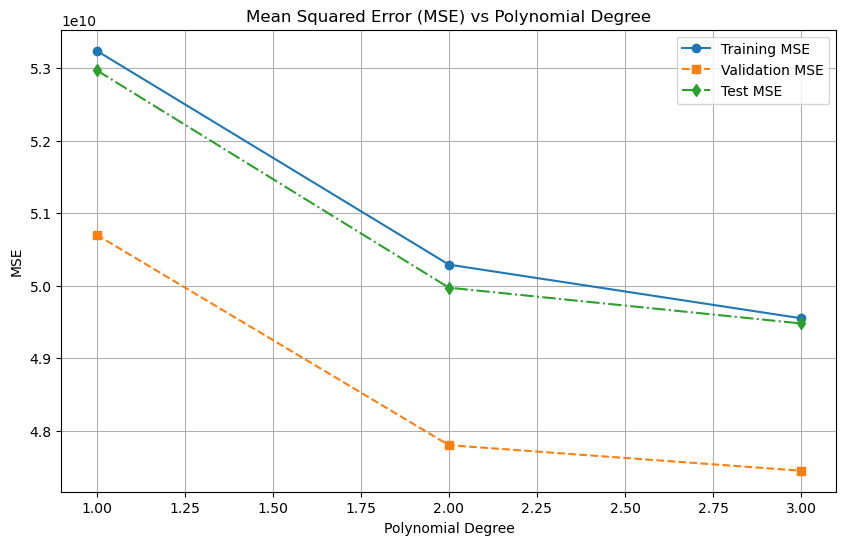

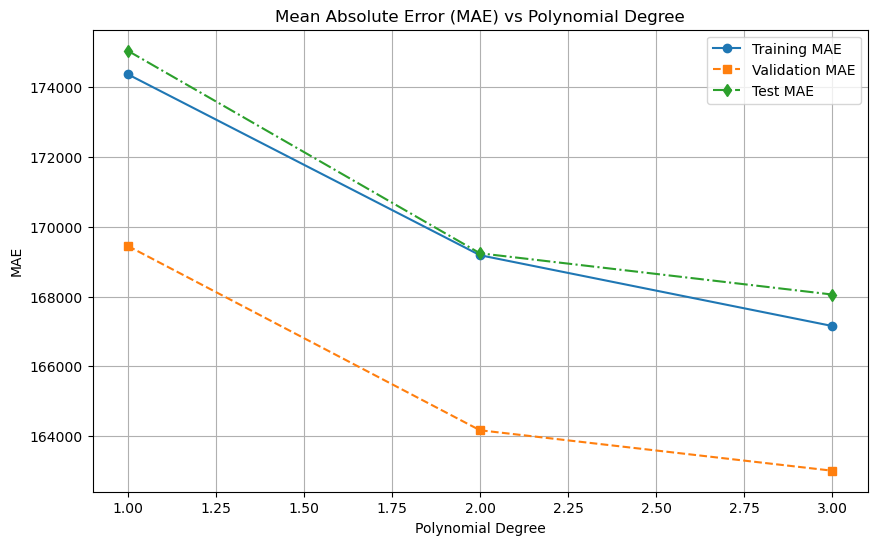

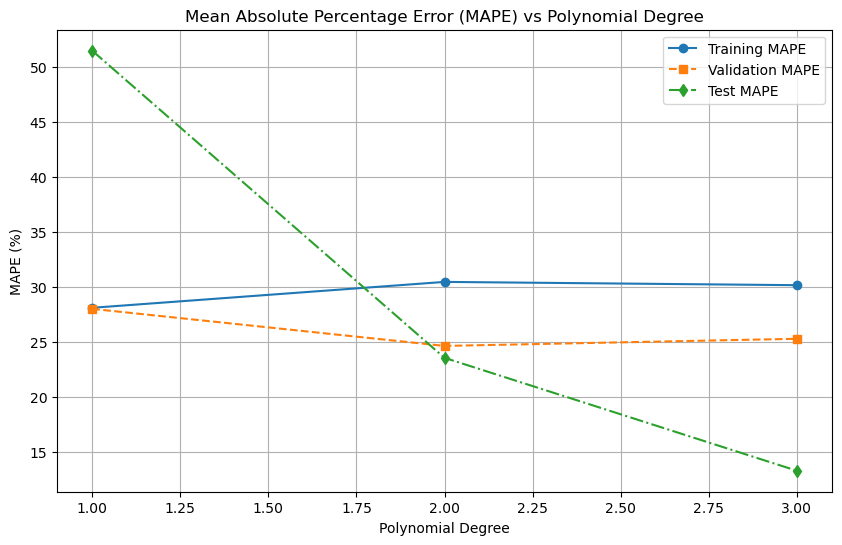

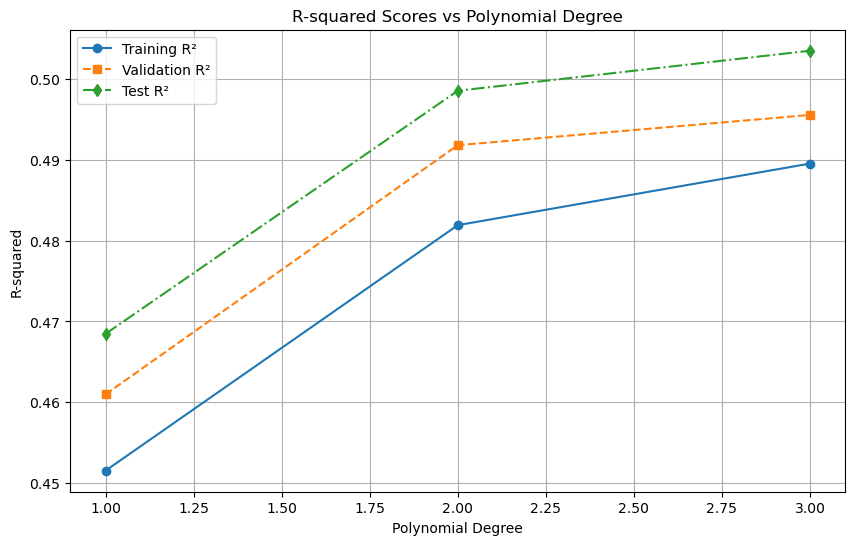

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

df = pd.read_csv('cleaned_dataset_without_close_to_zero.csv')

x = df.drop("price", axis=1)
y = df['price']
if (y <= 0).any():
    print("Warning: Found zero or negative values in 'price'. Adjusting values for log transformation.")

    print("Values in 'price' that are less than or equal to zero:")
    print(y[y <= 0])

    y = y + 1 

X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=0)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

r2_train_scores = []
r2_validation_scores = []
r2_test_scores = []

mse_train_scores = []
mse_validation_scores = []
mse_test_scores = []

mae_train_scores = []
mae_validation_scores = []
mae_test_scores = []

mape_train_scores = []
mape_validation_scores = []
mape_test_scores = []

columns_to_transform = ['bed', 'bath', 'house_size', 'log_bed', 'log_bath', 'square_bed', 'square_bath']

for degree in range(1, 4):
    print(f"\nPolynomial Degree: {degree}")

    poly = PolynomialFeatures(degree=degree, include_bias=False)

    X_train_poly = poly.fit_transform(X_train[columns_to_transform])

    poly_features_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out(columns_to_transform))

    X_train_final = pd.concat([poly_features_df, X_train.drop(columns=columns_to_transform).reset_index(drop=True)], axis=1)

    X_validation_poly = poly.transform(X_validation[columns_to_transform])
    validation_poly_features_df = pd.DataFrame(X_validation_poly, columns=poly.get_feature_names_out(columns_to_transform))
    X_validation_final = pd.concat([validation_poly_features_df, X_validation.drop(columns=columns_to_transform).reset_index(drop=True)], axis=1)
    
    X_test_poly = poly.transform(X_test[columns_to_transform])
    test_poly_features_df = pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out(columns_to_transform))
    X_test_final = pd.concat([test_poly_features_df, X_test.drop(columns=columns_to_transform).reset_index(drop=True)], axis=1)

    reg = LinearRegression().fit(X_train_final, y_train)

    y_pred_train = reg.predict(X_train_final)
    y_pred_validation = reg.predict(X_validation_final)
    y_pred_test = reg.predict(X_test_final)

    r2_train = reg.score(X_train_final, y_train)
    r2_validation = reg.score(X_validation_final, y_validation)
    r2_test = r2_score(y_test, y_pred_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_validation = mean_squared_error(y_validation, y_pred_validation)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_validation = mean_absolute_error(y_validation, y_pred_validation)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

    r2_train_scores.append(r2_train)
    r2_validation_scores.append(r2_validation)
    r2_test_scores.append(r2_test)

    mse_train_scores.append(mse_train)
    mse_validation_scores.append(mse_validation)
    mse_test_scores.append(mse_test)

    mae_train_scores.append(mae_train)
    mae_validation_scores.append(mae_validation)
    mae_test_scores.append(mae_test)

    mape_train_scores.append(mape_train)
    mape_validation_scores.append(mape_validation)
    mape_test_scores.append(mape_test)

    print(f"R-squared (Training set): {r2_train}")
    print(f"R-squared (Validation set): {r2_validation}")
    print(f"R-squared (Test set): {r2_test}")
    
    print(f"MSE (Training set): {mse_train}")
    print(f"MSE (Validation set): {mse_validation}")
    print(f"MSE (Test set): {mse_test}")
    
    print(f"MAE (Training set): {mae_train}")
    print(f"MAE (Validation set): {mae_validation}")
    print(f"MAE (Test set): {mae_test}")
    
    print(f"MAPE (Training set): {mape_train}")
    print(f"MAPE (Validation set): {mape_validation}")
    print(f"MAPE (Test set): {mape_test}")

degrees = range(1,4)

plt.figure(figsize=(10, 6))
plt.plot(degrees, mse_train_scores, label="Training MSE", marker='o', linestyle='-')
plt.plot(degrees, mse_validation_scores, label="Validation MSE", marker='s', linestyle='--')
plt.plot(degrees, mse_test_scores, label="Test MSE", marker='d', linestyle='-.')
plt.title("Mean Squared Error (MSE) vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(degrees, mae_train_scores, label="Training MAE", marker='o', linestyle='-')
plt.plot(degrees, mae_validation_scores, label="Validation MAE", marker='s', linestyle='--')
plt.plot(degrees, mae_test_scores, label="Test MAE", marker='d', linestyle='-.')
plt.title("Mean Absolute Error (MAE) vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(degrees, mape_train_scores, label="Training MAPE", marker='o', linestyle='-')
plt.plot(degrees, mape_validation_scores, label="Validation MAPE", marker='s', linestyle='--')
plt.plot(degrees, mape_test_scores, label="Test MAPE", marker='d', linestyle='-.')
plt.title("Mean Absolute Percentage Error (MAPE) vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("MAPE (%)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(degrees, r2_train_scores, label="Training R²", marker='o', linestyle='-')
plt.plot(degrees, r2_validation_scores, label="Validation R²", marker='s', linestyle='--')
plt.plot(degrees, r2_test_scores, label="Test R²", marker='d', linestyle='-.')

plt.title("R-squared Scores vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("R-squared")
plt.legend()
plt.grid(True)
plt.show()

#### Code for simple polynomial linear regression (previously first 6 degress, but made it 3, because it overfits after 3)

In [35]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor(strategy="mean")

dummy_reg.fit(X_train, y_train)

y_dummy_train_pred = dummy_reg.predict(X_train)
y_dummy_validation_pred = dummy_reg.predict(X_validation)
y_dummy_test_pred = dummy_reg.predict(X_test)

r2_dummy_train = r2_score(y_train, y_dummy_train_pred)
r2_dummy_validation = r2_score(y_validation, y_dummy_validation_pred)
r2_dummy_test = r2_score(y_test, y_dummy_test_pred)

mse_dummy_train = mean_squared_error(y_train, y_dummy_train_pred)
mse_dummy_validation = mean_squared_error(y_validation, y_dummy_validation_pred)
mse_dummy_test = mean_squared_error(y_test, y_dummy_test_pred)

mae_dummy_train = mean_absolute_error(y_train, y_dummy_train_pred)
mae_dummy_validation = mean_absolute_error(y_validation, y_dummy_validation_pred)
mae_dummy_test = mean_absolute_error(y_test, y_dummy_test_pred)

mape_dummy_train = mean_absolute_percentage_error(y_train, y_dummy_train_pred)
mape_dummy_validation = mean_absolute_percentage_error(y_validation, y_dummy_validation_pred)
mape_dummy_test = mean_absolute_percentage_error(y_test, y_dummy_test_pred)

print("\nBaseline (Dummy Regressor predicting mean) Results:")
print(f"R-squared (Training set): {r2_dummy_train}")
print(f"R-squared (Validation set): {r2_dummy_validation}")
print(f"R-squared (Test set): {r2_dummy_test}")

print(f"MSE (Training set): {mse_dummy_train}")
print(f"MSE (Validation set): {mse_dummy_validation}")
print(f"MSE (Test set): {mse_dummy_test}")

print(f"MAE (Training set): {mae_dummy_train}")
print(f"MAE (Validation set): {mae_dummy_validation}")
print(f"MAE (Test set): {mae_dummy_test}")

print(f"MAPE (Training set): {mape_dummy_train}")
print(f"MAPE (Validation set): {mape_dummy_validation}")
print(f"MAPE (Test set): {mape_dummy_test}")



Baseline (Dummy Regressor predicting mean) Results:
R-squared (Training set): 0.0
R-squared (Validation set): -6.985818481286543e-05
R-squared (Test set): -0.0003962477769865469
MSE (Training set): 97073841895.89825
MSE (Validation set): 94071705899.7716
MSE (Test set): 99699378005.28929
MAE (Training set): 249929.8527379615
MAE (Validation set): 247557.36697937263
MAE (Test set): 252535.3837349751
MAPE (Training set): 21.873941985094206
MAPE (Validation set): 54.819434757808864
MAPE (Test set): 54.81704098629888


#### Simple baseline as mean of y


Polynomial Degree: 1
Best alpha value found: 0.0011233240329780276
R-squared (Training set): 0.4547918427062928
R-squared (Validation set): 0.4608104581474286
R-squared (Test set): 0.46982865056409995
MSE (Training set): 61277271834.47803
MSE (Validation set): 58359045342.952
MSE (Test set): 58692322725.25313
MAE (Training set): 185983.27941233997
MAE (Validation set): 181908.90290369306
MAE (Test set): 182613.6110664879
MAPE (Training set): 33.390716843231615
MAPE (Validation set): 26.093186953544656
MAPE (Test set): 1.3755627428938921

Polynomial Degree: 2
Best alpha value found: 0.0001
R-squared (Training set): 0.4810629482017138
R-squared (Validation set): 0.48387488696593506
R-squared (Test set): 0.49685817912347674
MSE (Training set): 58324598343.996956
MSE (Validation set): 55862672652.55486
MSE (Test set): 55700033883.152664
MAE (Training set): 181141.8126379236
MAE (Validation set): 177531.0802381482
MAE (Test set): 177387.57822835285
MAPE (Training set): 33.91804373429016
MA

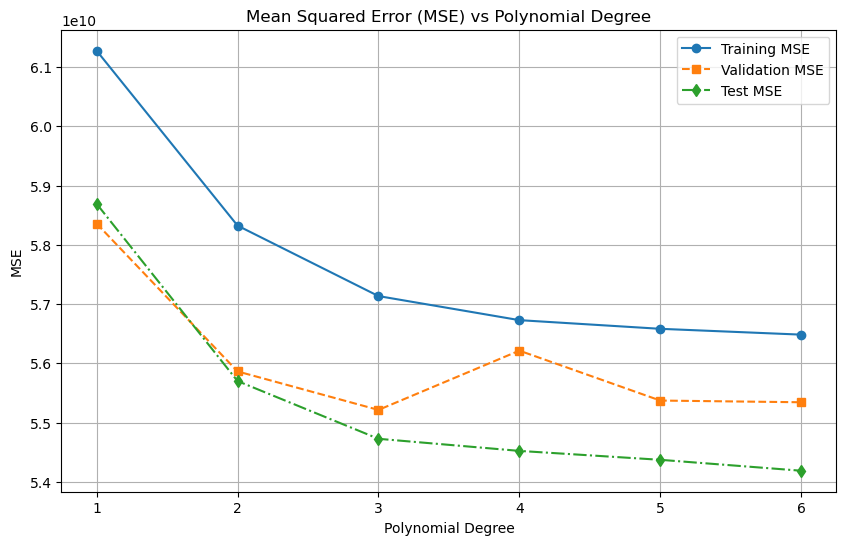

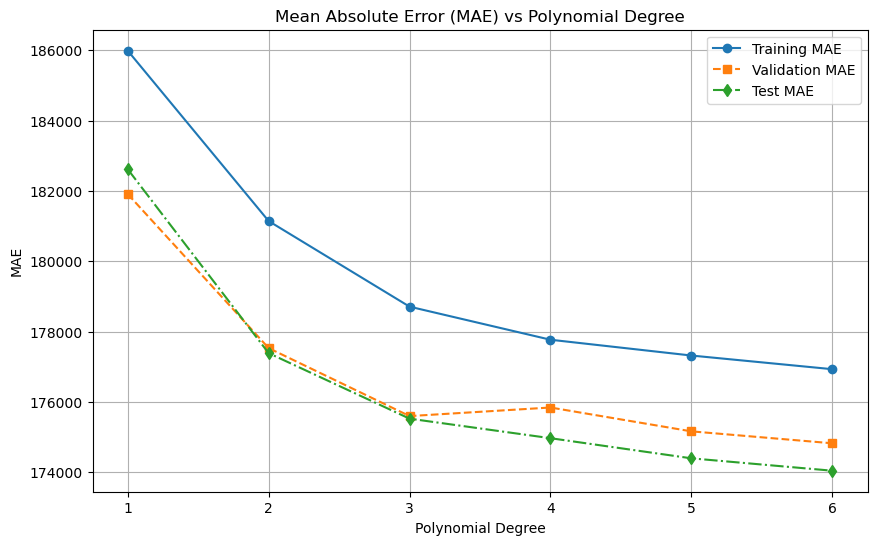

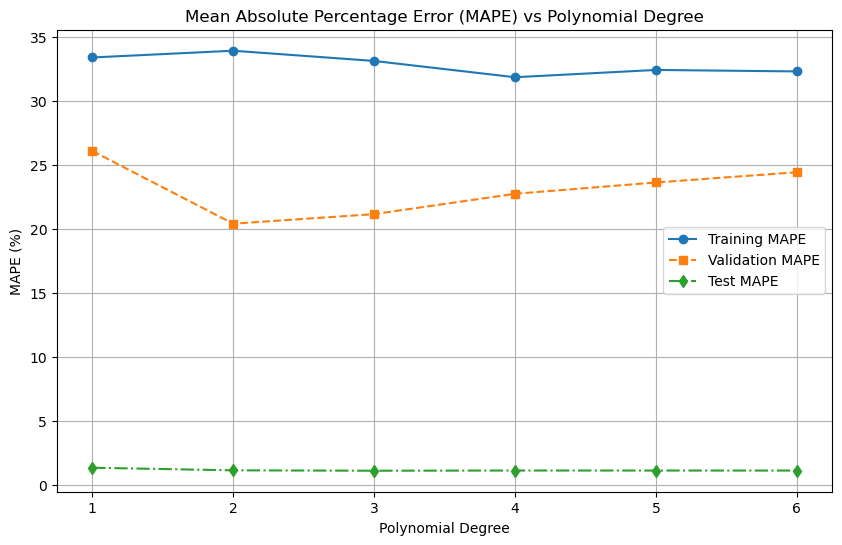

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

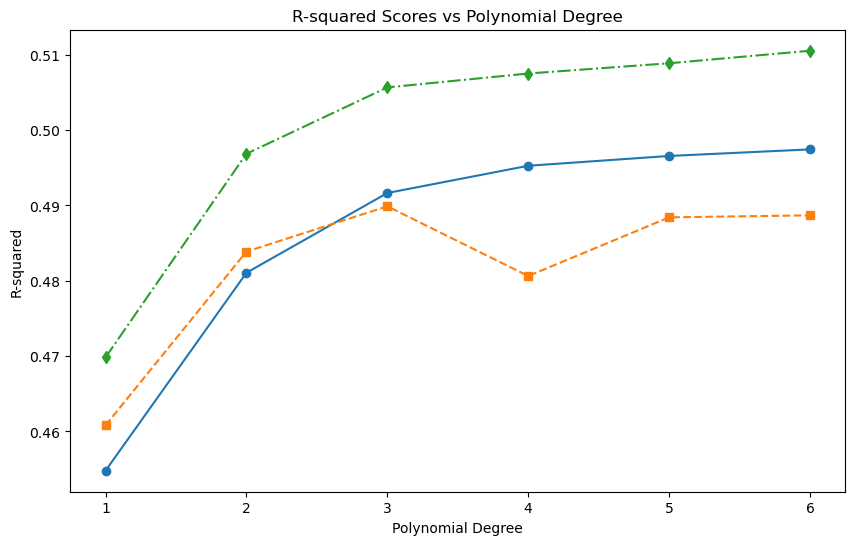

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

df = pd.read_csv('cleaned_dataset_without_close_to_zero.csv')

x = df.drop("price", axis=1)
y = df['price']

X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=0)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

columns_to_transform = ['bed', 'bath', 'house_size', 'log_bed', 'log_bath', 'square_bed', 'square_bath']

r2_train_scores = []
r2_validation_scores = []
r2_test_scores = []

mse_train_scores = []
mse_validation_scores = []
mse_test_scores = []

mae_train_scores = []
mae_validation_scores = []
mae_test_scores = []

mape_train_scores = []
mape_validation_scores = []
mape_test_scores = []

param_grid = {'alpha': np.logspace(-4, 4, 100)}

for degree in range(1, 7):
    print(f"\nPolynomial Degree: {degree}")
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)

    X_train_poly = poly.fit_transform(X_train[columns_to_transform])

    poly_features_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out(columns_to_transform))

    X_train_final = pd.concat([poly_features_df, X_train.drop(columns=columns_to_transform).reset_index(drop=True)], axis=1)

    X_validation_poly = poly.transform(X_validation[columns_to_transform])
    validation_poly_features_df = pd.DataFrame(X_validation_poly, columns=poly.get_feature_names_out(columns_to_transform))
    X_validation_final = pd.concat([validation_poly_features_df, X_validation.drop(columns=columns_to_transform).reset_index(drop=True)], axis=1)
    
    X_test_poly = poly.transform(X_test[columns_to_transform])
    test_poly_features_df = pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out(columns_to_transform))
    X_test_final = pd.concat([test_poly_features_df, X_test.drop(columns=columns_to_transform).reset_index(drop=True)], axis=1)

    ridge = Ridge()

    grid_search = GridSearchCV(ridge, param_grid, cv=3, scoring='r2', n_jobs=-1)

    grid_search.fit(X_train_final, y_train)

    best_alpha = grid_search.best_params_['alpha']
    print(f"Best alpha value found: {best_alpha}")

    reg = Ridge(alpha=best_alpha).fit(X_train_final, y_train)

    y_pred_train = reg.predict(X_train_final)
    y_pred_validation = reg.predict(X_validation_final)
    y_pred_test = reg.predict(X_test_final)

    r2_train = reg.score(X_train_final, y_train)
    r2_validation = reg.score(X_validation_final, y_validation)
    r2_test = r2_score(y_test, y_pred_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_validation = mean_squared_error(y_validation, y_pred_validation)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_validation = mean_absolute_error(y_validation, y_pred_validation)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

    r2_train_scores.append(r2_train)
    r2_validation_scores.append(r2_validation)
    r2_test_scores.append(r2_test)

    mse_train_scores.append(mse_train)
    mse_validation_scores.append(mse_validation)
    mse_test_scores.append(mse_test)

    mae_train_scores.append(mae_train)
    mae_validation_scores.append(mae_validation)
    mae_test_scores.append(mae_test)

    mape_train_scores.append(mape_train)
    mape_validation_scores.append(mape_validation)
    mape_test_scores.append(mape_test)

    print(f"R-squared (Training set): {r2_train}")
    print(f"R-squared (Validation set): {r2_validation}")
    print(f"R-squared (Test set): {r2_test}")
    
    print(f"MSE (Training set): {mse_train}")
    print(f"MSE (Validation set): {mse_validation}")
    print(f"MSE (Test set): {mse_test}")
    
    print(f"MAE (Training set): {mae_train}")
    print(f"MAE (Validation set): {mae_validation}")
    print(f"MAE (Test set): {mae_test}")
    
    print(f"MAPE (Training set): {mape_train}")
    print(f"MAPE (Validation set): {mape_validation}")
    print(f"MAPE (Test set): {mape_test}")

degrees = range(1, 7)

plt.figure(figsize=(10, 6))
plt.plot(degrees, mse_train_scores, label="Training MSE", marker='o', linestyle='-')
plt.plot(degrees, mse_validation_scores, label="Validation MSE", marker='s', linestyle='--')
plt.plot(degrees, mse_test_scores, label="Test MSE", marker='d', linestyle='-.')
plt.title("Mean Squared Error (MSE) vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(degrees, mae_train_scores, label="Training MAE", marker='o', linestyle='-')
plt.plot(degrees, mae_validation_scores, label="Validation MAE", marker='s', linestyle='--')
plt.plot(degrees, mae_test_scores, label="Test MAE", marker='d', linestyle='-.')
plt.title("Mean Absolute Error (MAE) vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(degrees, mape_train_scores, label="Training MAPE", marker='o', linestyle='-')
plt.plot(degrees, mape_validation_scores, label="Validation MAPE", marker='s', linestyle='--')
plt.plot(degrees, mape_test_scores, label="Test MAPE", marker='d', linestyle='-.')
plt.title("Mean Absolute Percentage Error (MAPE) vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("MAPE (%)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(degrees, r2_train_scores, label="Training R²", marker='o', linestyle='-')
plt.plot(degrees, r2_validation_scores, label="Validation R²", marker='s', linestyle='--')
plt.plot(degrees, r2_test_scores, label="Test R²", marker='d', linestyle='-.')

plt.title("R-squared Scores vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("R-squared")
plt.legend


#### Code for regularized polynomial regressor

In [11]:
df = pd.read_csv('New_York.csv')

# WARNING: AFTER THIS POINT, THE ENTIRE CODE IS TESTING THE FEATURES FOR RELEVANCE. THE DATASET FOR IT MAY NOT BE AVAILABLE
# Part 2

<Axes: >

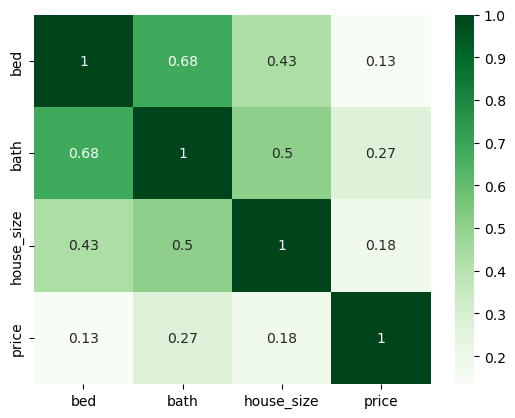

In [12]:
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['city']
numerical_features = ['bed', 'bath', 'house_size']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X = df.drop('price', axis=1)
y = df['price']

X_transformed = preprocessor.fit_transform(X)

matrix = df[numerical_features + ['price']].corr()
sns.heatmap(matrix, cmap="Greens", annot=True)

#### Checking correlation between features.
#### The original correlation graph can be seen in the presentation (this one doesn't have acre_lot)

In [16]:
df = pd.read_csv('cleaned_dataset.csv')

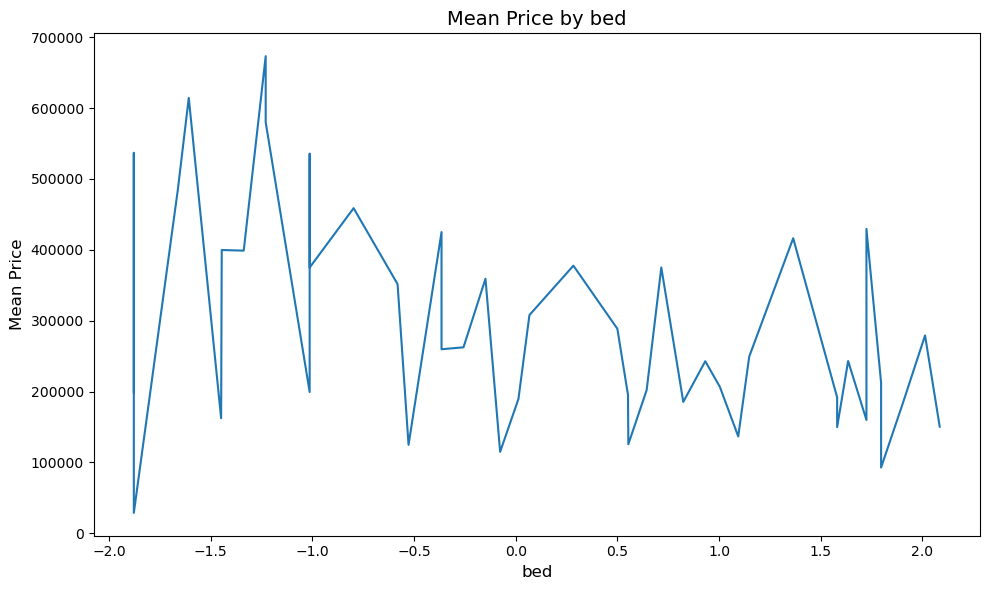

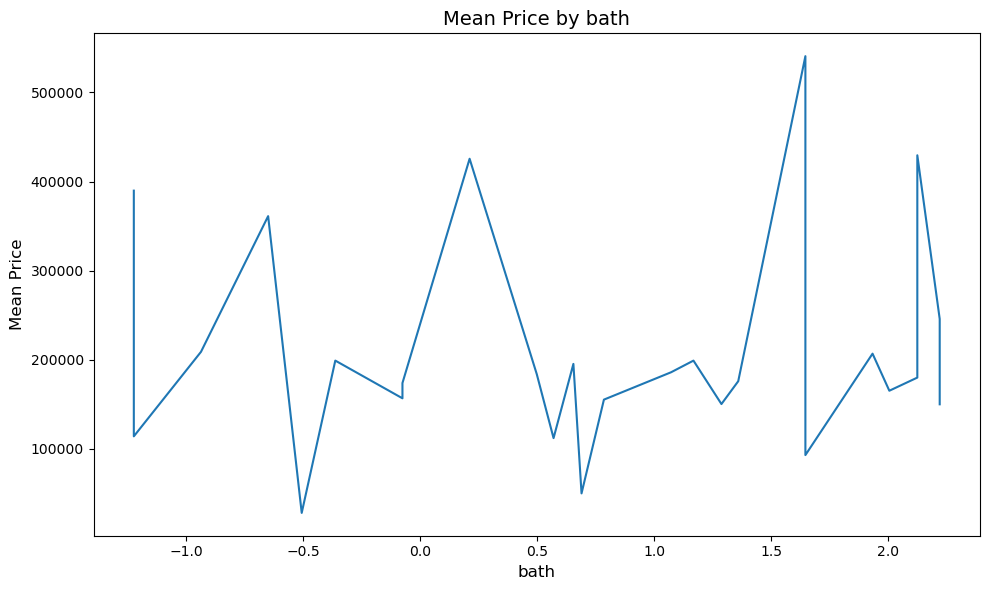

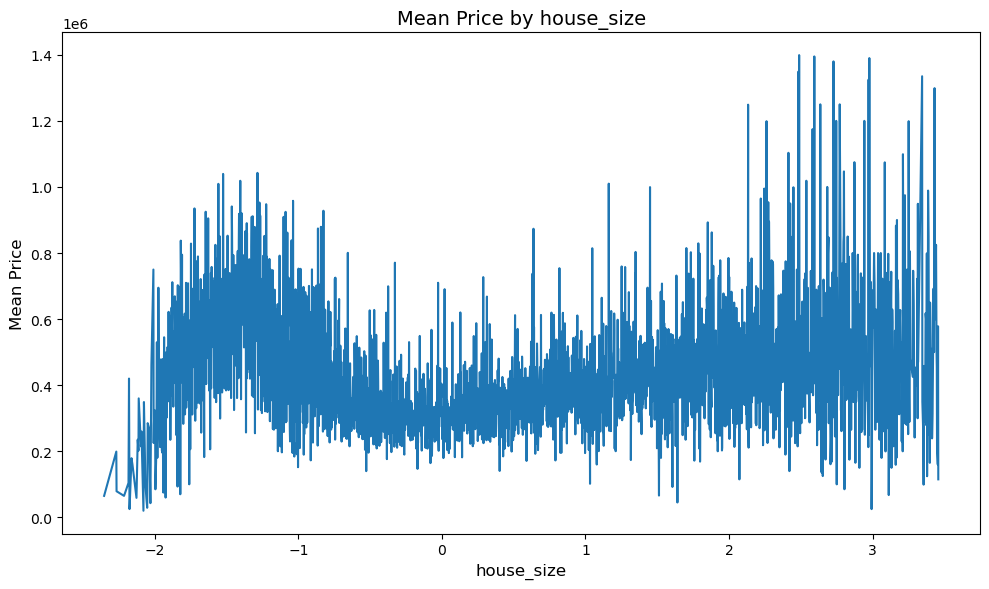

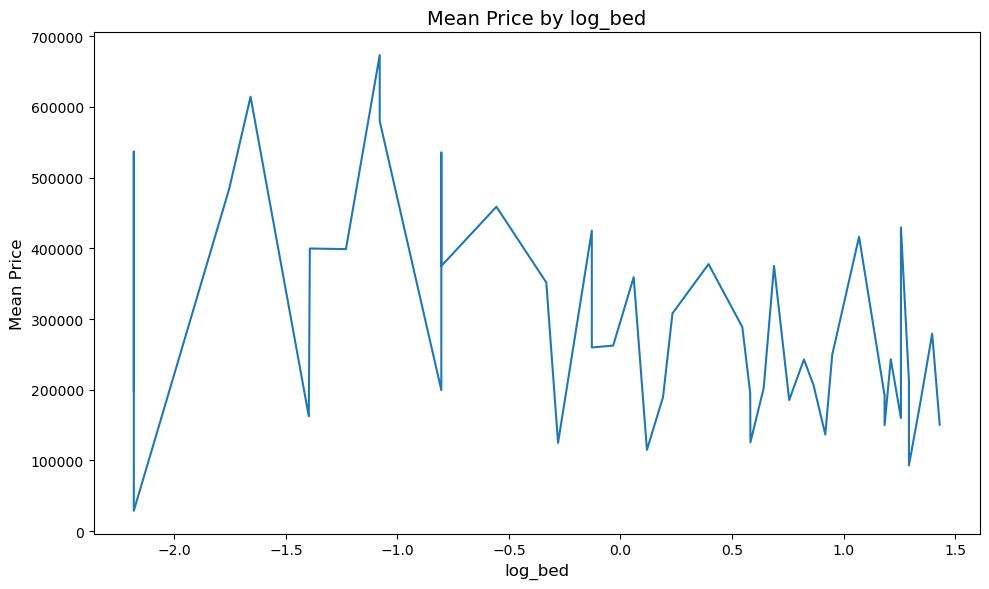

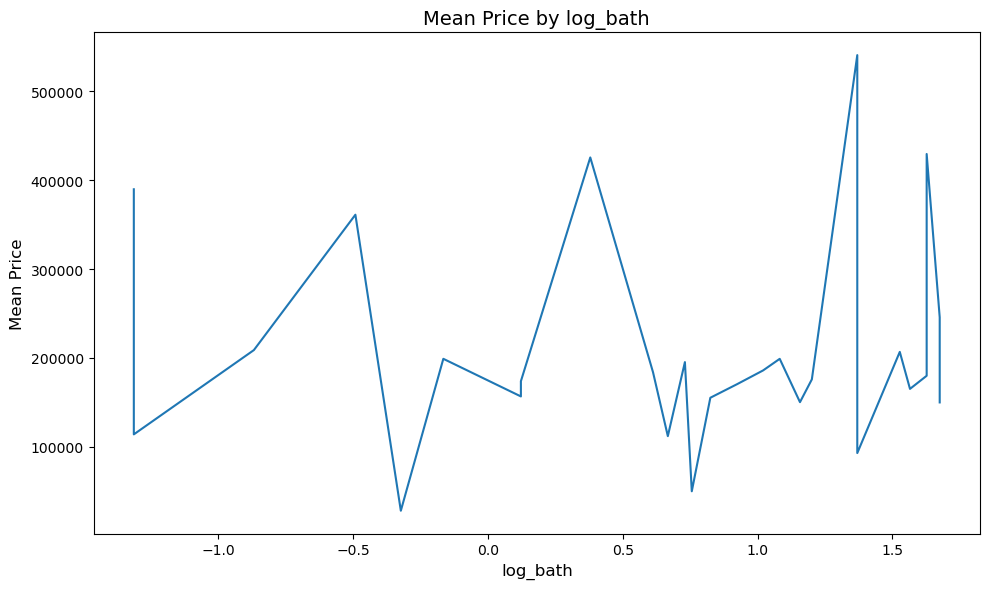

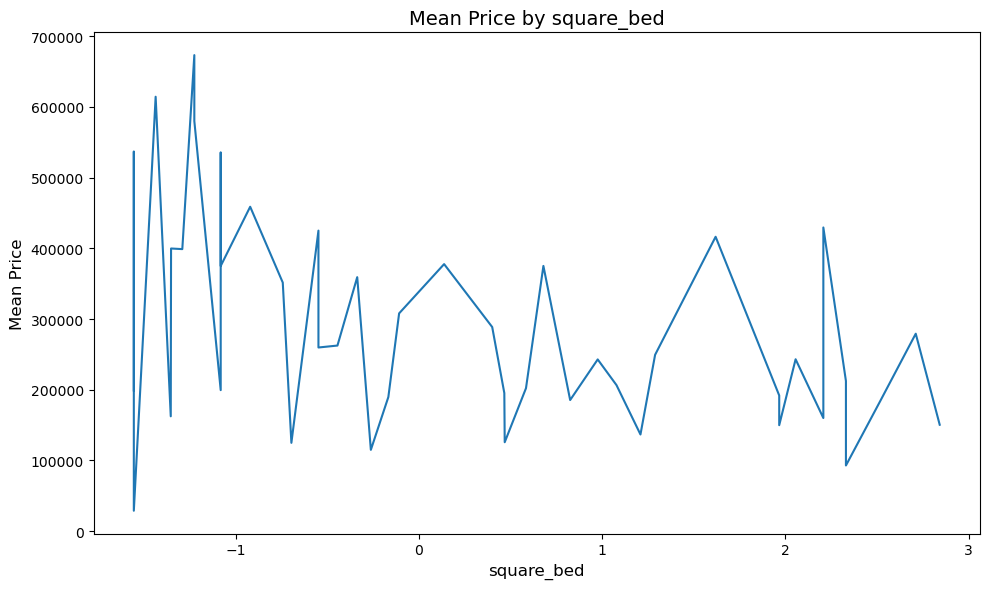

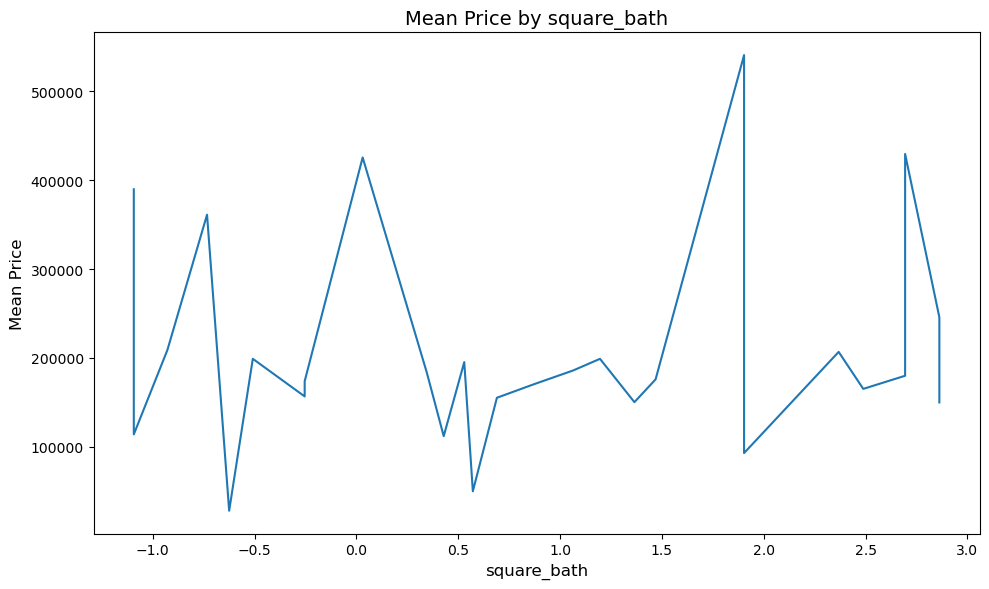

In [19]:
columns_to_scale = ['bed', 'bath', 'house_size', 'log_bed', 'log_bath', 'square_bed', 'square_bath']

for num_feature in columns_to_scale:
    df_sorted = df[[num_feature, 'price']].sort_values(by=num_feature)

    grouped_data = df_sorted.groupby(num_feature).mean().reset_index()

    plt.figure(figsize=(10, 6))

    sns.lineplot(x=grouped_data[num_feature], y=grouped_data['price'], marker="")

    plt.title(f'Mean Price by {num_feature}', fontsize=14)
    plt.xlabel(num_feature, fontsize=12)
    plt.ylabel('Mean Price', fontsize=12)

    plt.tight_layout()
    plt.show()

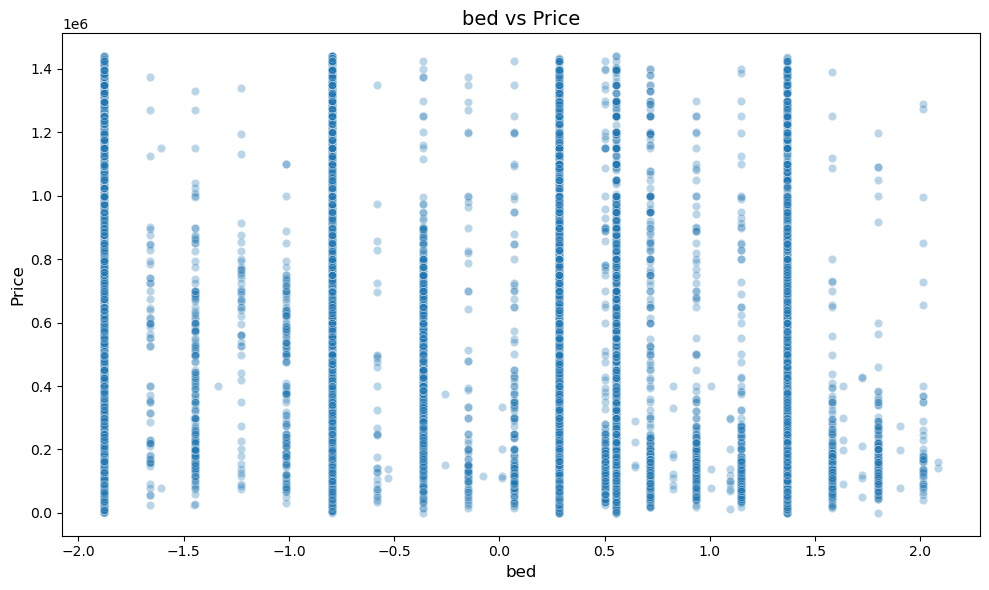

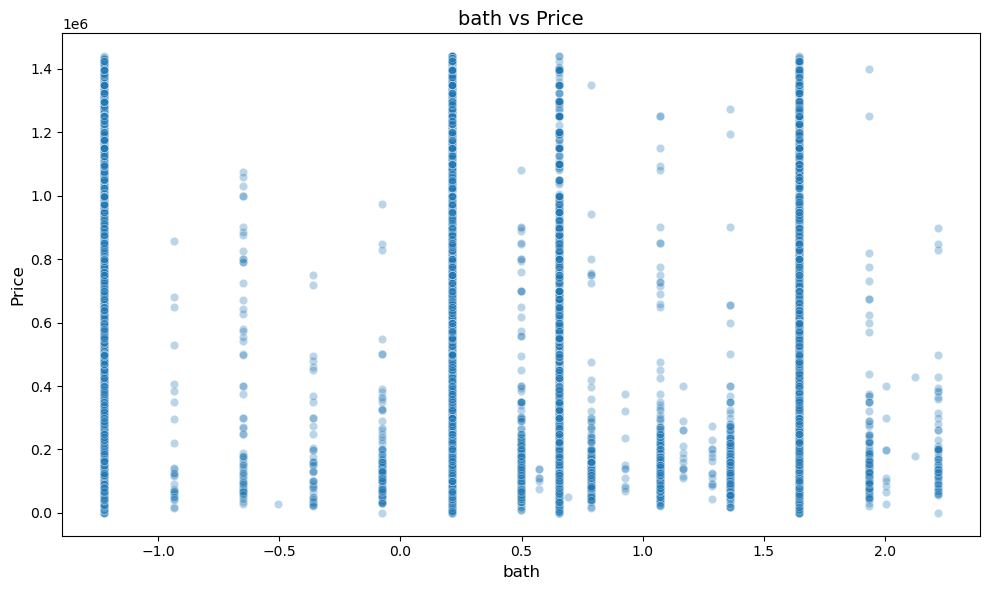

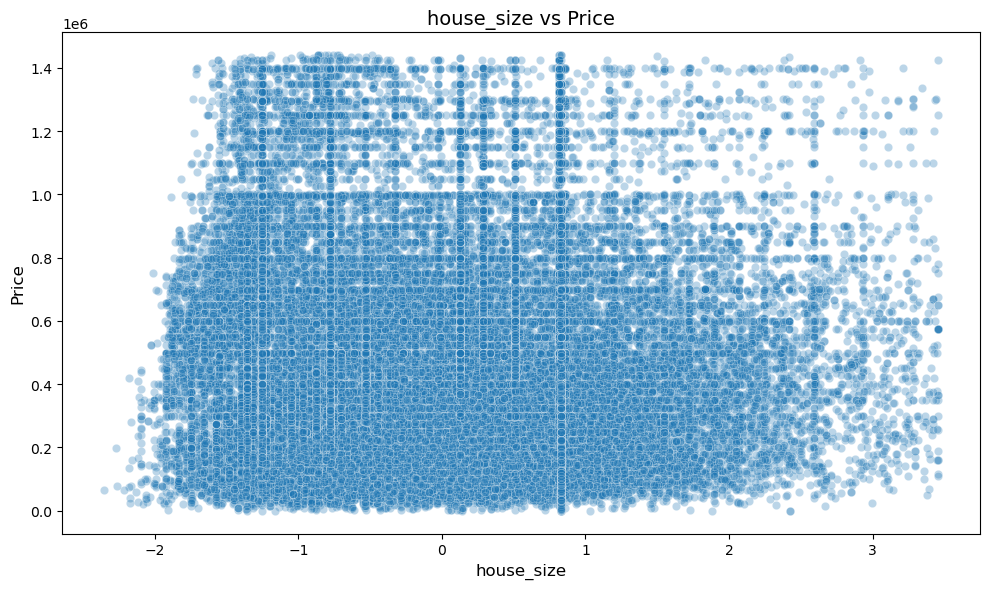

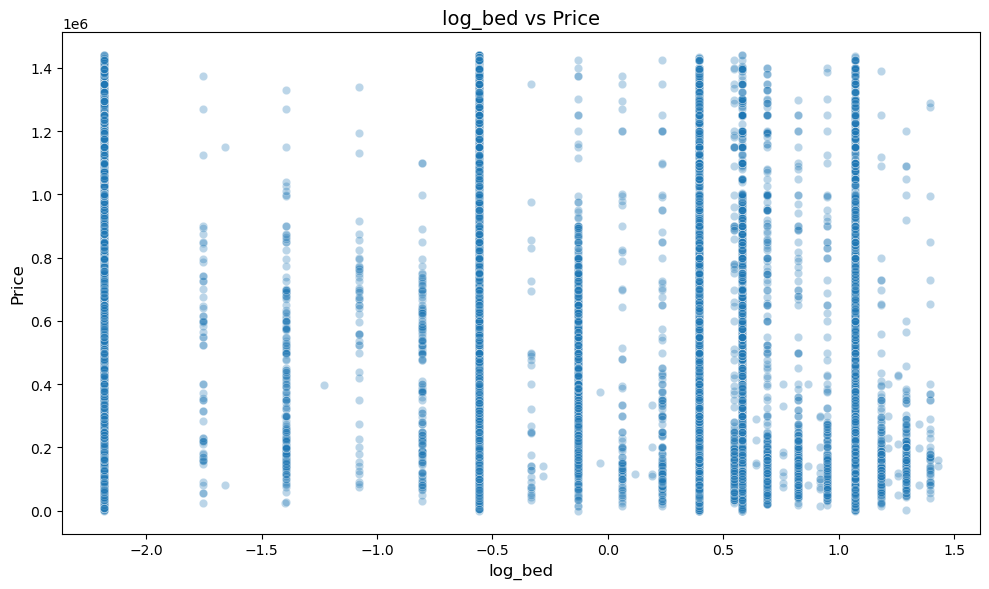

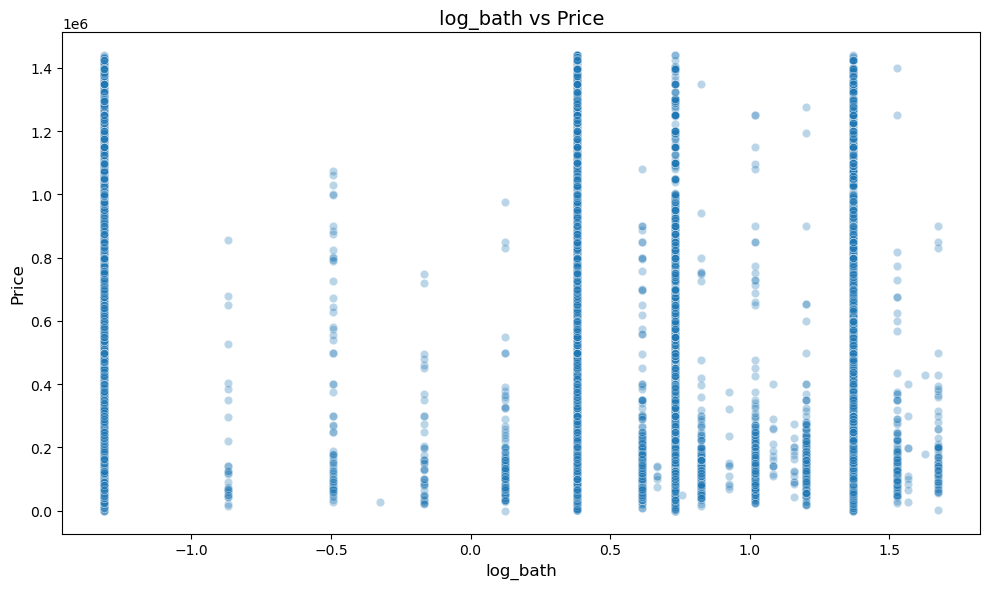

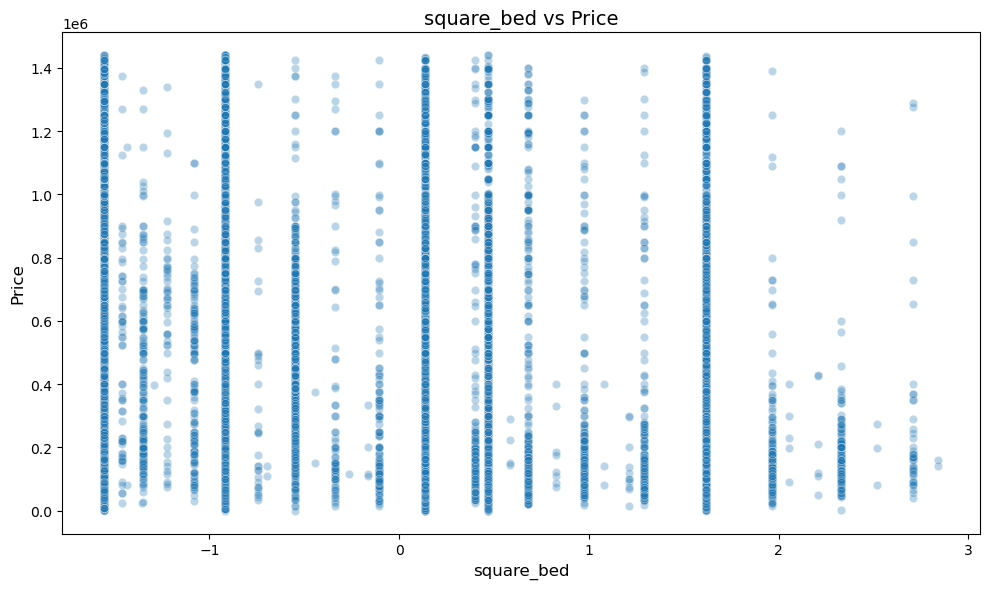

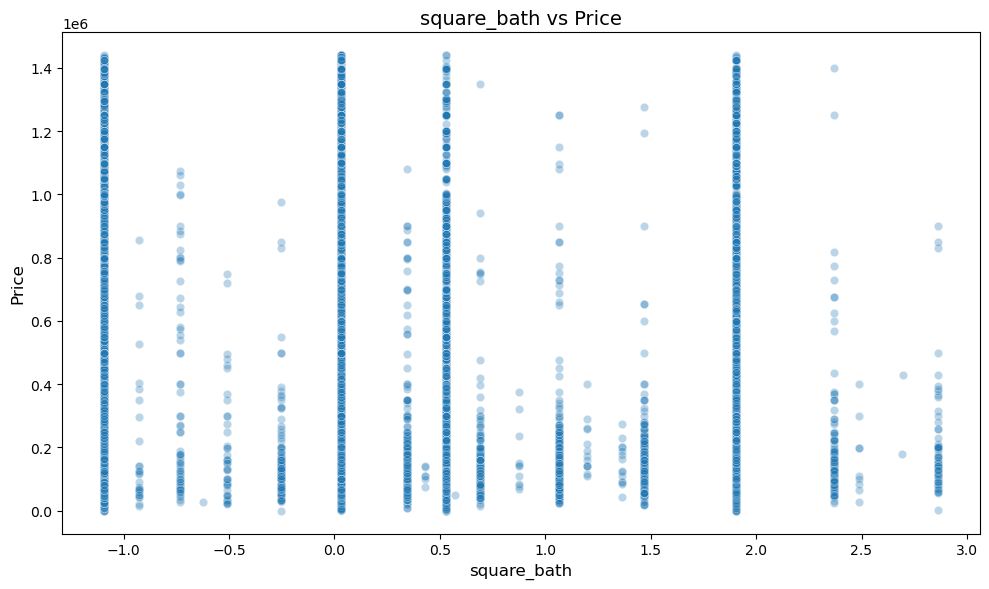

In [18]:
for num_feature in columns_to_scale:
  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=num_feature, y='price', data=df, alpha=0.3)

  plt.title(f'{num_feature} vs Price', fontsize=14)
  plt.xlabel(num_feature, fontsize=12)
  plt.ylabel('Price', fontsize=12)

  plt.tight_layout()
  plt.show()

In [40]:
brokered_by_count = df['brokered_by'].value_counts()
city_count = df['city'].value_counts()

top_30_brokers = brokered_by_count.head(30).index.tolist()
top_30_cities = city_count.head(30).index.tolist()

df['brokered_by_grouped'] = df['brokered_by'].apply(lambda x: x if x in top_30_brokers else 'Other Brokers')

df['city_grouped'] = df['city'].apply(lambda x: x if x in top_30_cities else 'Other Cities')

grouped_broker_count = df['brokered_by_grouped'].value_counts()
grouped_city_count = df['city_grouped'].value_counts()

grouped_broker_percent = (grouped_broker_count / grouped_broker_count.sum()) * 100
grouped_city_percent = (grouped_city_count / grouped_city_count.sum()) * 100

print("Grouped Broker Counts (in Percent):")
print(grouped_broker_percent)

print("\nGrouped City Counts (in Percent):")
print(grouped_city_percent)

Grouped Broker Counts (in Percent):
brokered_by_grouped
Other Brokers    74.345355
23592.0           3.718150
24196.0           2.336339
29034.0           1.669933
91607.0           1.666013
16829.0           1.642493
22022.0           1.358291
22552.0           1.182869
45690.0           1.107409
52568.0           0.934927
28958.0           0.931007
10485.0           0.792826
33714.0           0.757546
41924.0           0.561544
105716.0          0.557624
53299.0           0.550764
53224.0           0.500784
53512.0           0.494904
20086.0           0.456684
8514.0            0.415523
79021.0           0.410623
108517.0          0.397883
81944.0           0.376323
45949.0           0.372403
30768.0           0.365543
22550.0           0.360643
45488.0           0.356723
53221.0           0.355743
26692.0           0.349863
88180.0           0.342023
10368.0           0.331243
Name: count, dtype: float64

Grouped City Counts (in Percent):
city_grouped
Other Cities     56.363191
New 

#### This one happened on an old dataset that still had brokered_by and city columns to check whether we should group them into 30 best

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

label_encoders = {}
X_cat = df.copy()

for cat_feature in categorical_features:
    le = LabelEncoder()
    X_cat[cat_feature] = le.fit_transform(X_cat[cat_feature])
    label_encoders[cat_feature] = le 

X_combined = X_cat[categorical_features + numerical_features]

model = RandomForestRegressor()
model.fit(X_combined, y)

importance = pd.Series(model.feature_importances_, index=X_combined.columns)

importance = importance.sort_values(ascending=False)

KeyError: 'city'

#### This happened when the dataset was simpler (without logs and squares and 30 cities), so features were easier to group

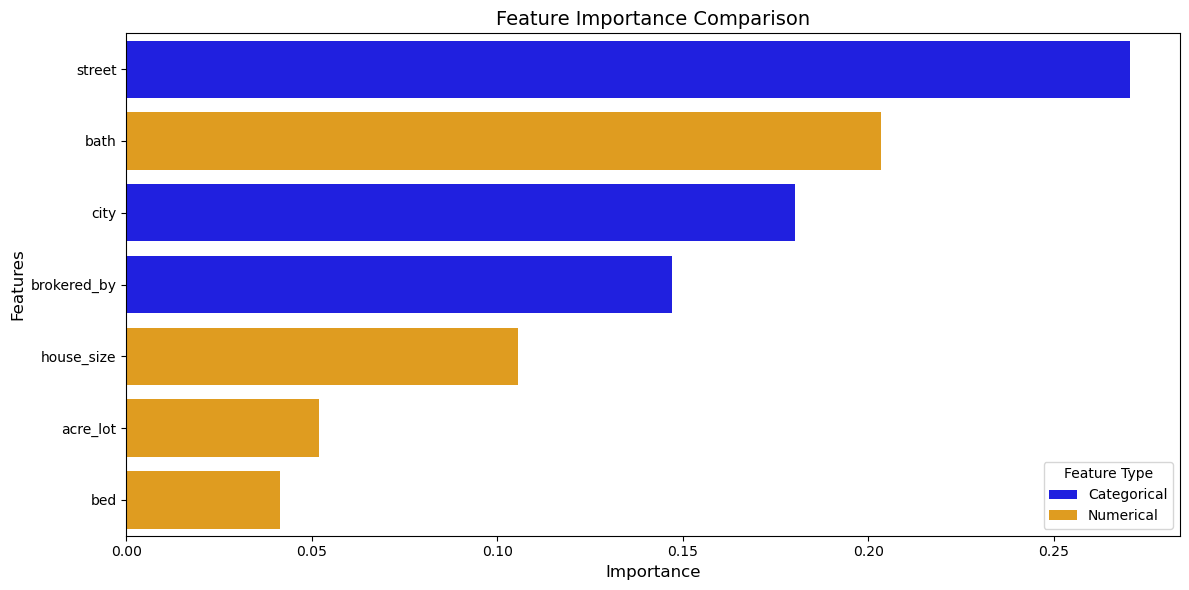

In [15]:
importance_df = importance.reset_index()
importance_df.columns = ['Feature', 'Importance']

importance_df['Type'] = importance_df['Feature'].apply(lambda x: 'Categorical' if x in categorical_features else 'Numerical')

color_map = {'Categorical': 'blue', 'Numerical': 'orange'}

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', hue='Type', dodge=False, palette=color_map)
plt.title('Feature Importance Comparison', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.legend(title='Feature Type')
plt.tight_layout()
plt.show()

#### The result of feature comparison was this

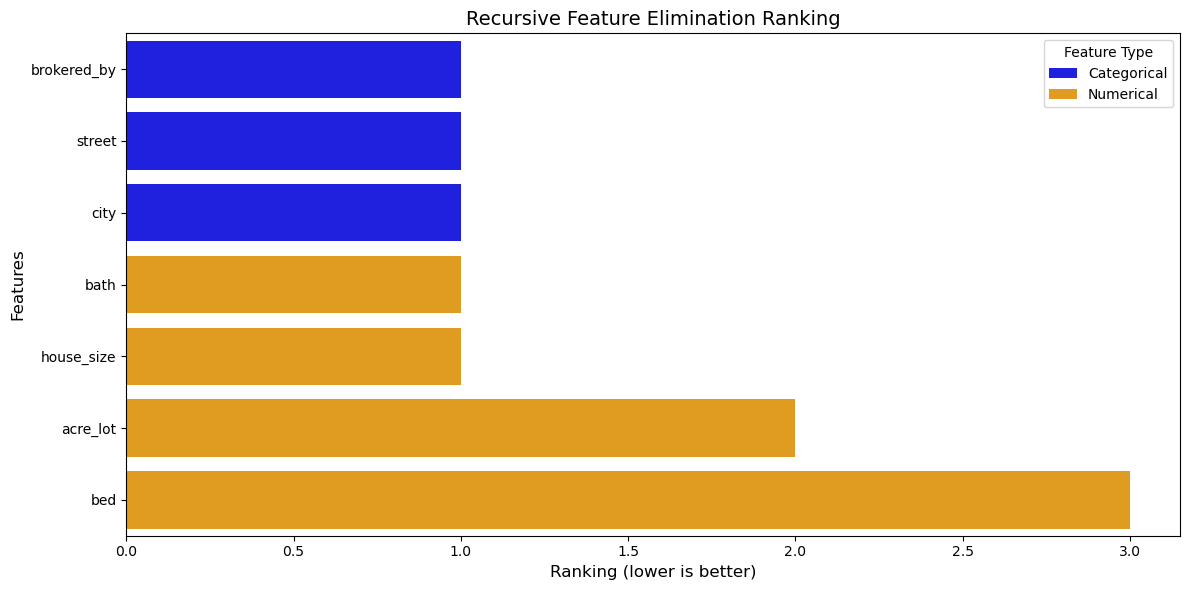

In [16]:
from sklearn.feature_selection import RFE

model = RandomForestRegressor()

selector = RFE(model, n_features_to_select=5)
selector = selector.fit(X_combined, y)

ranking = selector.ranking_

rfe_importance_df = pd.DataFrame({'Feature': X_combined.columns, 'Ranking': ranking})
rfe_importance_df = rfe_importance_df.sort_values('Ranking')

rfe_importance_df['Type'] = rfe_importance_df['Feature'].apply(lambda x: 'Categorical' if x in categorical_features else 'Numerical')

color_map = {'Categorical': 'blue', 'Numerical': 'orange'}

plt.figure(figsize=(12, 6))
sns.barplot(data=rfe_importance_df, x='Ranking', y='Feature', hue='Type', dodge=False, palette=color_map)
plt.title('Recursive Feature Elimination Ranking', fontsize=14)
plt.xlabel('Ranking (lower is better)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.legend(title='Feature Type')
plt.tight_layout()
plt.show()

#### Result of RFE was this


Polynomial Degree: 3


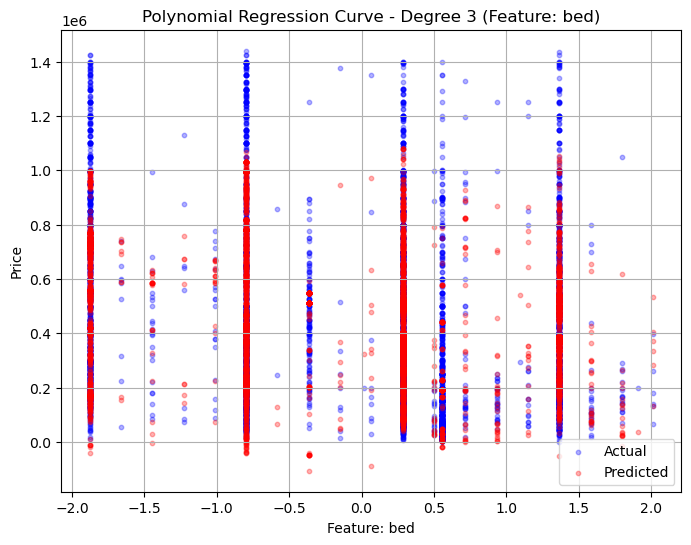

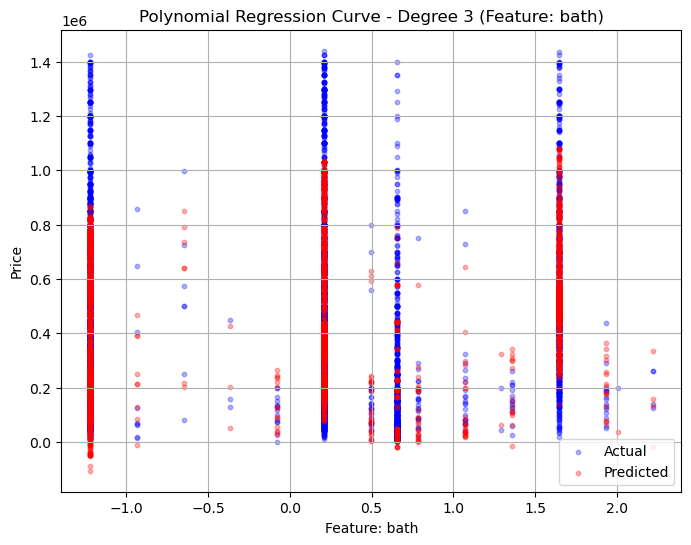

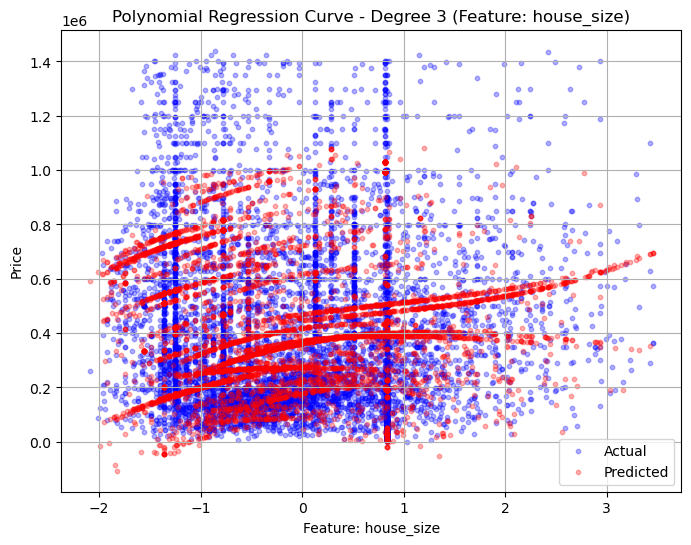

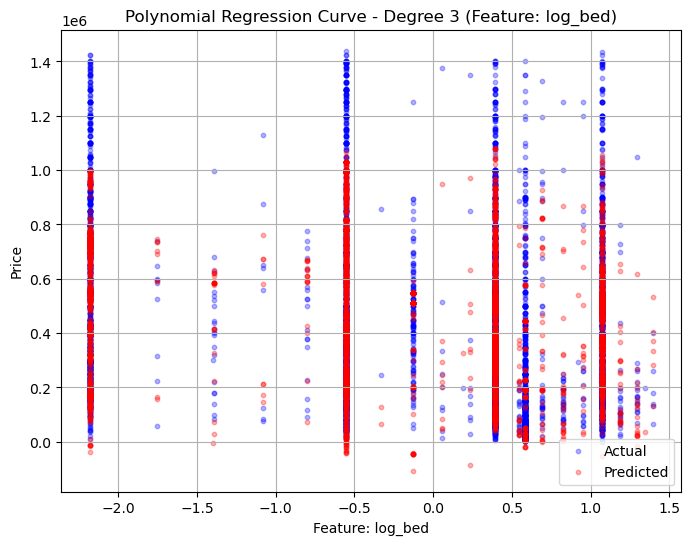

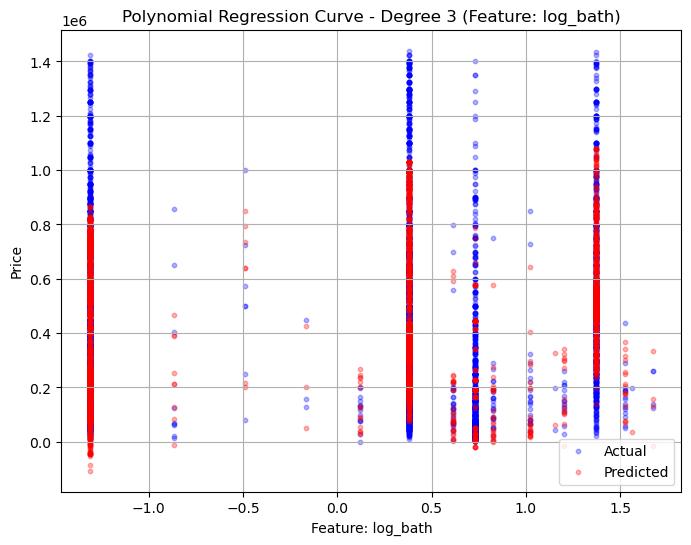

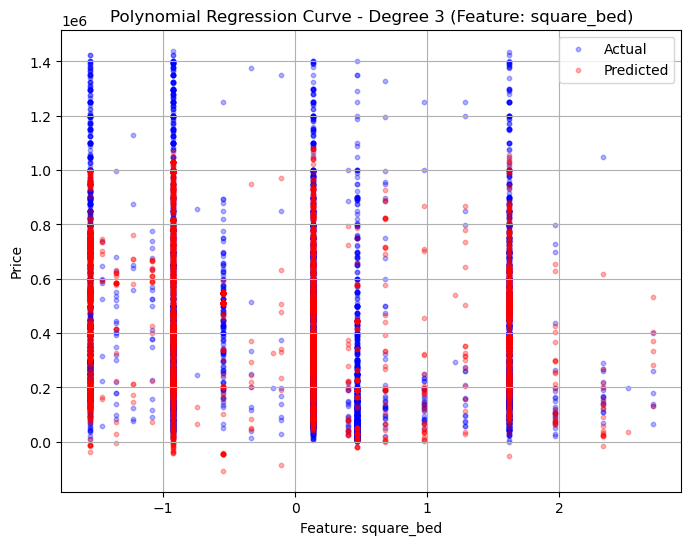

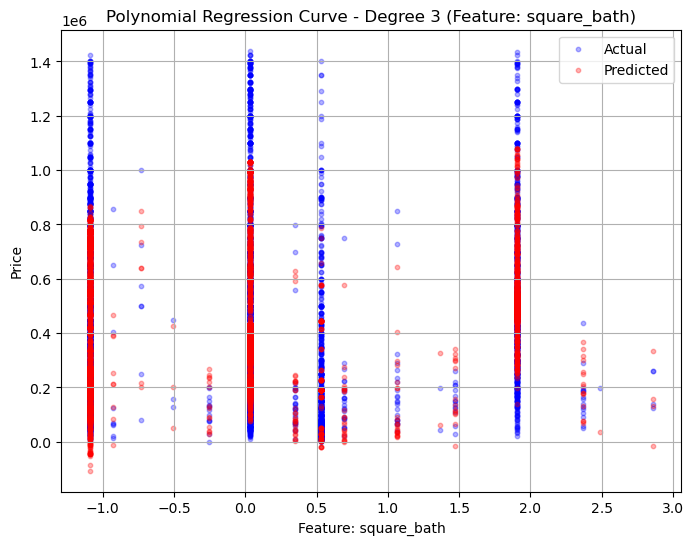

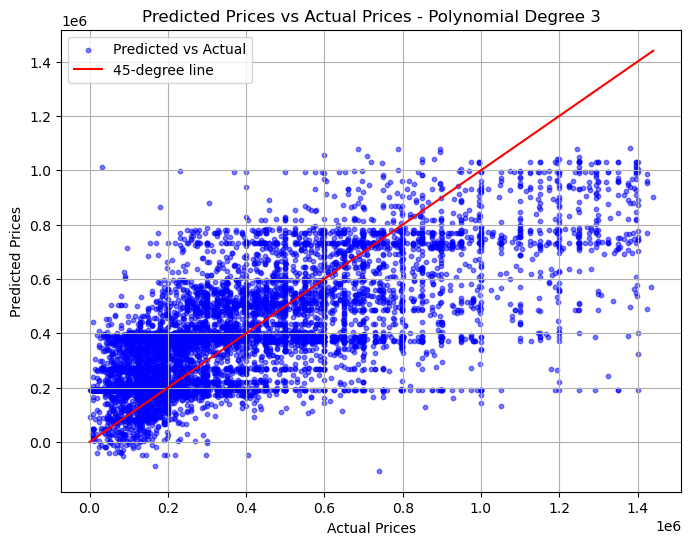

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

print(f"\nPolynomial Degree: {3}")

df = pd.read_csv('cleaned_dataset_without_close_to_zero.csv')

x = df.drop("price", axis=1)
y = df['price']
if (y <= 0).any():
    print("Warning: Found zero or negative values in 'price'. Adjusting values for log transformation.")

    print("Values in 'price' that are less than or equal to zero:")
    print(y[y <= 0])

    y = y + 1 

X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=0)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

columns_to_transform = ['bed', 'bath', 'house_size', 'log_bed', 'log_bath', 'square_bed', 'square_bath']

poly = PolynomialFeatures(degree=3, include_bias=False)

X_train_poly = poly.fit_transform(X_train[columns_to_transform])

poly_features_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out(columns_to_transform))

X_train_final = pd.concat([poly_features_df, X_train.drop(columns=columns_to_transform).reset_index(drop=True)], axis=1)

X_validation_poly = poly.transform(X_validation[columns_to_transform])
validation_poly_features_df = pd.DataFrame(X_validation_poly, columns=poly.get_feature_names_out(columns_to_transform))
X_validation_final = pd.concat([validation_poly_features_df, X_validation.drop(columns=columns_to_transform).reset_index(drop=True)], axis=1)

X_test_poly = poly.transform(X_test[columns_to_transform])
test_poly_features_df = pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out(columns_to_transform))
X_test_final = pd.concat([test_poly_features_df, X_test.drop(columns=columns_to_transform).reset_index(drop=True)], axis=1)

reg = LinearRegression().fit(X_train_final, y_train)

y_pred_test = reg.predict(X_test_final)

for i, column in enumerate(columns_to_transform):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test[column], y_test, color='blue', label='Actual', s = 10, alpha = 0.3)
    plt.scatter(X_test[column], y_pred_test, color='red', label='Predicted', s = 10, alpha = 0.3)
    
    plt.title(f"Polynomial Regression Curve - Degree {3} (Feature: {column})")
    plt.xlabel(f"Feature: {column}")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, color='blue', label='Predicted vs Actual', s=10, alpha=0.5)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='45-degree line')

plt.title("Predicted Prices vs Actual Prices - Polynomial Degree 3")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.grid(True)
plt.show()

#### Performed a simple check on polynomial degree 3